# Customer Churn Analysis and Prediction Modeling
#### Glit Hanpanitkitkan
#### 2025-12-29

In [67]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

from sklearn.preprocessing import StandardScaler # Z-score normalization (mean = 0, sd = 1)
from sklearn.preprocessing import OneHotEncoder # turn categories into numeric columns
from sklearn.compose import ColumnTransformer # apply different preprocessing to different column groups
from sklearn.pipeline import Pipeline # preprocessing and model into a single object

import warnings

## Project Overview
**Research Question:**

What are the driving factors that help determine whether a customer stays or leave a telecommunications company? How can we predict whether a customer will churn based on these variables?

**Motivation**

Customer retention is a critical objective for many companies, particularly in subscription-based and highly competitive industries such as telecommunications. With numerous alternatives available and low switching costs, customers can easily change providers, making churn a persistent challenge.

Understanding customer characteristics, preferences, and service usage is essential for identifying the factors that drive satisfaction and churn. By leveraging data-driven insights, companies can design targeted strategies to improve customer experience, reduce churn, and remain competitive.

**Outline**

This project analyzes customer churn using the IBM Telco Customer Churn dataset, a publicly available dataset provided by IBM. The dataset contains detailed information about customers of a telecommunications service provider and is designed to help understand the factors that influence whether a customer leaves (churns) or stays with the company.

The data includes demographic attributes (such as gender, senior citizen status, and dependents), account and service details (contract type, payment method, internet and phone services), and billing information (monthly charges, total charges, and tenure). We are also given whether or not a customer churns or not.

Some important variables to understand include:

* `Senior Citizen`: Indicates if the customer is 65 or older

* `Partner`: Indicates if the customer is married

* `Dependents`: Indicates if the customer lives with any dependents

* `Tenure Months`: Indicates the total amount of months that the customer has been with the company by the end of the quarter.

* `Phone Service`: Indicates if the customer subscribes to home phone service with the company.

* `Multiple Lines`: Indicates if the customer subscribes to multiple telephone lines with the company.

* `Internet Service`: Indicates if the customer subscribes to Internet service with the company.

* `Online Security`: Indicates if the customer subscribes to an additional online security service.

* `Paperless Billing`: Indicates if the customer has chosen paperless billing.

* `Tech Support`: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times.

* `Monthly Charges`: Indicates the customer’s current total monthly charge for all their services from the company.

* `Total Charges`: Indicates the customer’s total charges, calculated to the end of the quarter.

* `CLTV`: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

* `Churn Value`: 1 = the customer left the company this quarter. 0 = the customer remained with the company.

In [68]:
# Load Data
df = pd.read_csv("customers.csv")
print(df.shape)
df.head(5)

(7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


Note that many of the columns in this dataset are labeled as Yes/No, meaning they represent binary outcomes with only two possible values. From a data analysis perspective, it is best practice to encode binary variables as 0 (No/False) and 1 (Yes/True). This numeric encoding allows these features to be more easily analyzed, visualized, and incorporated into statistical models and machine learning algorithms, many of which require numerical inputs and interpret binary values more effectively in mathematical operations.

In [69]:
# Turn yes/no into binary 1 and 0

# Convert 'Senior Citizen' column
df.loc[df['Senior Citizen'] != 'Yes', 'Senior Citizen'] = 0
df.loc[df['Senior Citizen'] == 'Yes', 'Senior Citizen'] = 1
df['Senior Citizen'] = df['Senior Citizen'].astype(int)


# Convert 'Partner' column
df.loc[df['Partner'] != 'Yes', 'Partner'] = 0
df.loc[df['Partner'] == 'Yes', 'Partner'] = 1
df['Partner'] = df['Partner'].astype(int)


# Convert 'Dependents' column
df.loc[df['Dependents'] != 'Yes', 'Dependents'] = 0
df.loc[df['Dependents'] == 'Yes', 'Dependents'] = 1
df['Dependents'] = df['Dependents'].astype(int)


# Convert Phone Service
df.loc[df['Phone Service'] != 'Yes', 'Phone Service'] = 0
df.loc[df['Phone Service'] == 'Yes', 'Phone Service'] = 1
df['Phone Service'] = df['Phone Service'].astype(int)

# Convert Multiple Lines
df.loc[df['Multiple Lines'] != 'Yes', 'Multiple Lines'] = 0
df.loc[df['Multiple Lines'] == 'Yes', 'Multiple Lines'] = 1
df['Multiple Lines'] = df['Multiple Lines'].astype(int)


# Add a column on whether customer has internet service or not
df.loc[df['Internet Service'] == 'No', 'Has Internet Service'] = 0
df.loc[df['Internet Service'] != 'No', 'Has Internet Service'] = 1
df['Has Internet Service'] = df['Has Internet Service'].astype(int)

df.loc[df['Online Security'] != 'Yes', 'Online Security'] = 0
df.loc[df['Online Security'] == 'Yes', 'Online Security'] = 1
df['Online Security'] = df['Online Security'].astype(int)


df.loc[df['Online Backup'] != 'Yes', 'Online Backup'] = 0
df.loc[df['Online Backup'] == 'Yes', 'Online Backup'] = 1
df['Online Backup'] = df['Online Backup'].astype(int)


df.loc[df['Device Protection'] != 'Yes', 'Device Protection'] = 0
df.loc[df['Device Protection'] == 'Yes', 'Device Protection'] = 1
df['Device Protection'] = df['Device Protection'].astype(int)


df.loc[df['Tech Support'] != 'Yes', 'Tech Support'] = 0
df.loc[df['Tech Support'] == 'Yes', 'Tech Support'] = 1
df['Tech Support'] = df['Tech Support'].astype(int)


df.loc[df['Streaming TV'] != 'Yes', 'Streaming TV'] = 0
df.loc[df['Streaming TV'] == 'Yes', 'Streaming TV'] = 1
df['Streaming TV'] = df['Streaming TV'].astype(int)


df.loc[df['Streaming Movies'] != 'Yes', 'Streaming Movies'] = 0
df.loc[df['Streaming Movies'] == 'Yes', 'Streaming Movies'] = 1
df['Streaming Movies'] = df['Streaming Movies'].astype(int)


df.loc[df['Paperless Billing'] != 'Yes', 'Paperless Billing'] = 0
df.loc[df['Paperless Billing'] == 'Yes', 'Paperless Billing'] = 1
df['Paperless Billing'] = df['Paperless Billing'].astype(int)


df.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Has Internet Service
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,1,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,1,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,1,Electronic check,99.65,820.5,Yes,1,86,5372,Moved,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,1,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,1,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices,1


In [70]:
# Data Cleaning

# Converting Total Charges to a number column
if 'Total Charges' in df.columns:
    df['Total Charges'] = pd.to_numeric(df['Monthly Charges'], errors='coerce')
df = df.dropna(subset=['Total Charges']).copy()

if 'CustomerID' in df.columns:
    df = df.drop(columns=['CustomerID'])

print(df.shape)
print(df.isna().sum().sort_values(ascending=False).head(10))


(7043, 33)
Churn Reason       5174
Count                 0
Online Backup         0
CLTV                  0
Churn Score           0
Churn Value           0
Churn Label           0
Total Charges         0
Monthly Charges       0
Payment Method        0
dtype: int64



Churn rate: 0.265


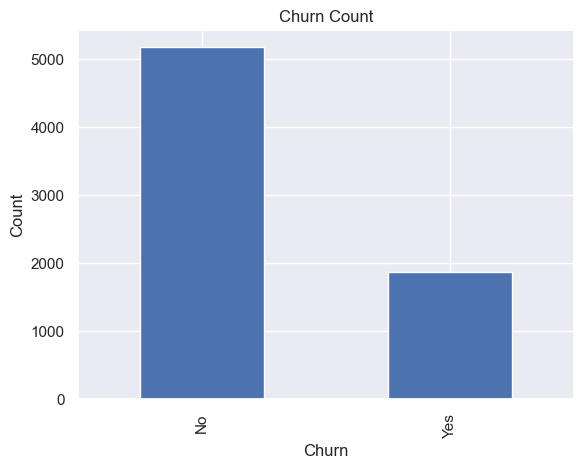

In [71]:
sns.set_theme()

# Churn rate
churn_rate = df["Churn Value"].mean()
print(f"\nChurn rate: {churn_rate:.3f}")

plt.figure()
df["Churn Label"].value_counts().plot(kind="bar")
plt.title("Churn Count")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()

Recall that the features we converted from Yes/No to 0 and 1 are still categorical variables since they represent a category rather than a quantitative range of numbers.

Let's separate these categorical variables from the numerical variables and visualize them separately first.

In [72]:
categorical_features = ["Senior Citizen", "Partner", "Dependents", "Phone Service", "Multiple Lines", "Online Security",
                       "Online Backup", "Device Protection", "Tech Support", "Streaming TV", "Streaming Movies", "Paperless Billing", "Has Internet Service"]

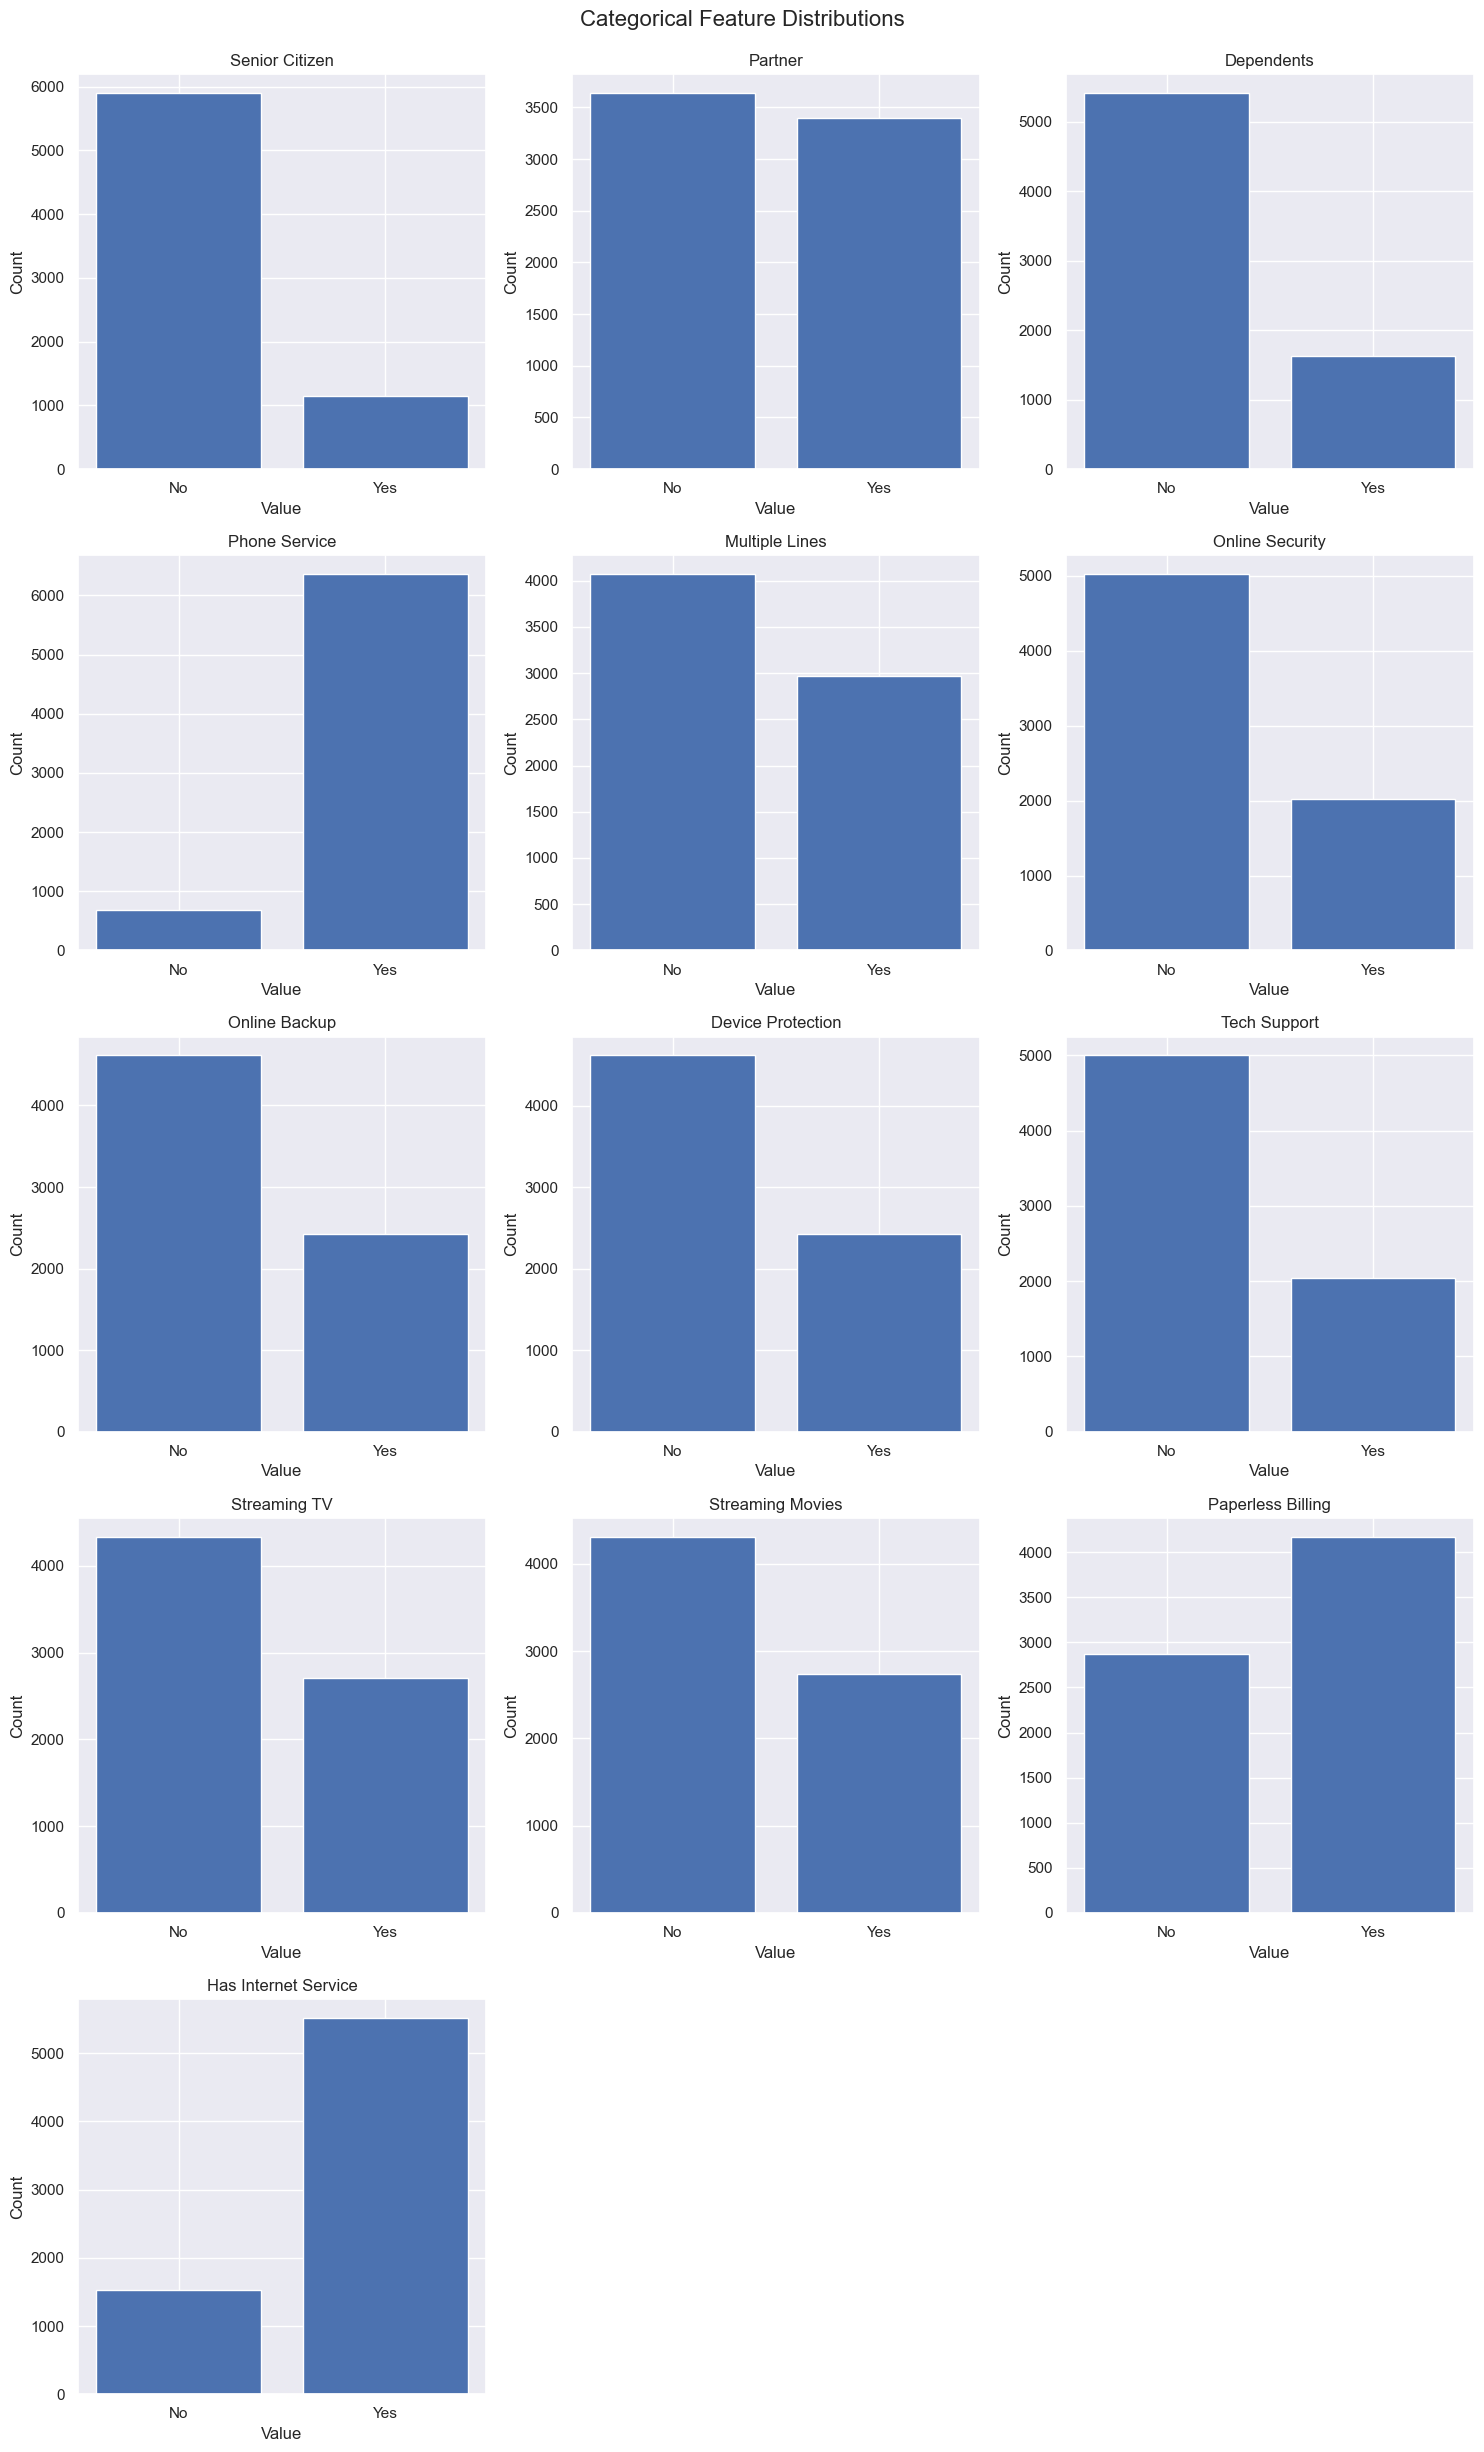

In [73]:
n_features = len(categorical_features)

n_cols = 3
n_rows = math.ceil(n_features / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    counts = df[col].value_counts().sort_index()
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Count")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["No", "Yes"])

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Categorical Feature Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()

Numerical Columns: ['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']


<Figure size 640x480 with 0 Axes>

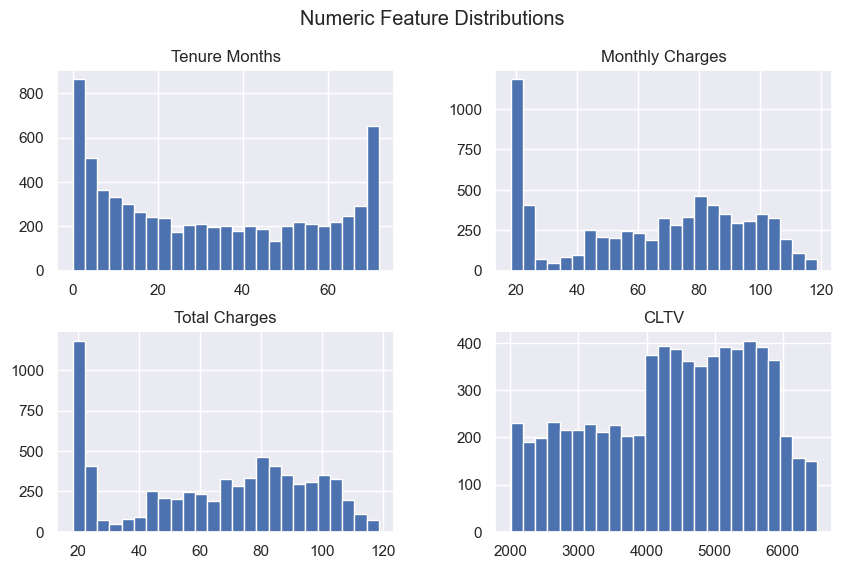

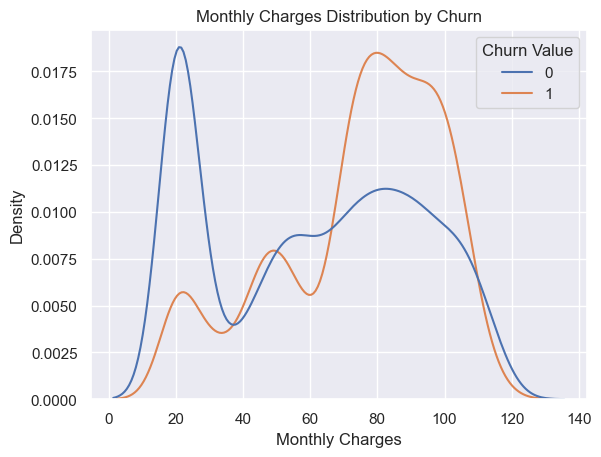

In [74]:
# Numeric distributions
#col_nums = df.select_dtypes(include=[np.number]).columns.tolist()
col_nums = df[['Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV']]
#col_nums = [c for c in col_nums if c != "Churn Value" and c != "Count" and c != "Zip Code" and c != "Churn Score" and c != "Latitude" and c != "Longitude" ]
col_nums = [c for c in col_nums]
print(f"Numerical Columns: {col_nums}")

if col_nums:
    plt.figure()
    df[col_nums].hist(bins=25, figsize=(10, 6))
    plt.suptitle("Numeric Feature Distributions")
    plt.show()

# Relationship example: MonthlyCharges vs churn
if "Monthly Charges" in df.columns:
    plt.figure()
    sns.kdeplot(data=df, x="Monthly Charges", hue="Churn Value", common_norm=False)
    plt.title("Monthly Charges Distribution by Churn")
    plt.show()

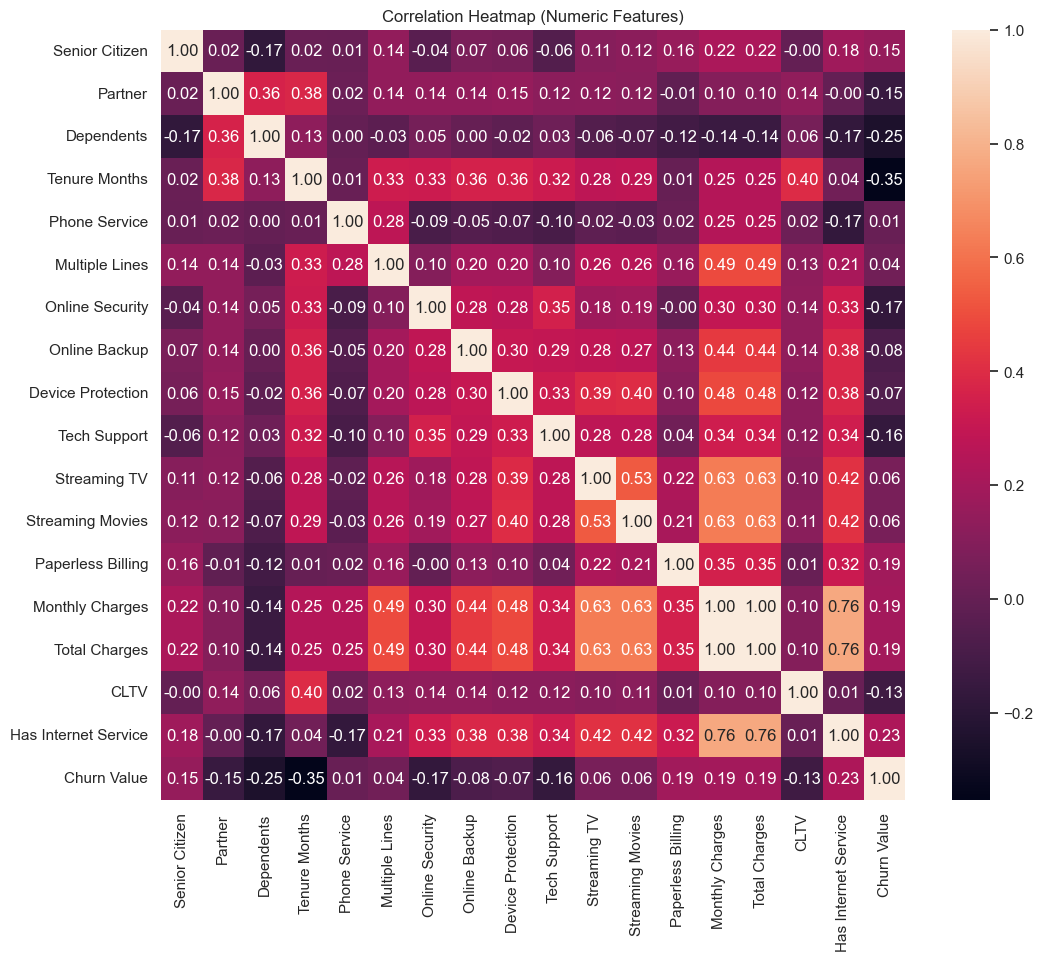

In [75]:
key_features = df.select_dtypes(include=[np.number]).columns.tolist()
key_features = [c for c in key_features if c != "Churn Value" and c != "Count" and c != "Zip Code" and c != "Churn Score" and c != "Latitude" and c != "Longitude" ]

# Correlation heatmap (numeric only)
if len(key_features) >= 2:
    plt.figure(figsize=(12, 10))
    corr = df[key_features + ["Churn Value"]].corr(numeric_only=True)
    sns.heatmap(corr, annot=True, fmt=".2f")
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.show()

We can see that the features that have the highest correlation with the `churn_value` are [in order of magnitude] `Tenure Months`, `Dependents`, `has_internet_service`, `Monthly Charges`, `Total Charges`, etc.

Since many features have low correlation on the `churn_value`, let's only use the top features that will have the most impact on helping predicting whether a customer churns.

In [76]:
X = df[['Tenure Months', 'Dependents', 'Has Internet Service', 'Monthly Charges', 'Total Charges', 'Paperless Billing', 'Tech Support',
        'Senior Citizen', 'Partner', 'Online Security', 'CLTV']]
X.head(5)

,Tenure Months,Dependents,Has Internet Service,Monthly Charges,Total Charges,Paperless Billing,Tech Support,Senior Citizen,Partner,Online Security,CLTV
0,2,0,1,53.85,53.85,1,0,0,0,1,3239
1,2,1,1,70.70,70.70,1,0,0,0,0,2701
2,8,1,1,99.65,99.65,1,0,0,0,0,5372
3,28,1,1,104.80,104.80,1,1,0,1,0,5003
4,49,1,1,103.70,103.70,1,0,0,0,0,5340


Recall that many of the features in this dataset are numerical in nature, whether they are continuous variables (such as tenure or monthly charges) or binary indicators encoded as 0 and 1. These numerical features are well suited for predictive modeling and can be leveraged to estimate a customer’s likelihood of remaining with or leaving the company.

Because customer churn is a binary outcome—either a customer stays or churns—the problem is naturally framed as a binary classification task. Our objective is to estimate the probability of churn based on the selected features and to understand which factors contribute most strongly to this outcome. To accomplish this, we consider several classification models that are well suited to this task, including logistic regression, decision tree classifiers, and random forest models.

Logistic regression provides a strong baseline due to its interpretability and ability to model probabilities directly. Decision trees offer intuitive, rule-based insights into customer behavior by capturing non-linear relationships and feature interactions. Random forests, as an ensemble of decision trees, further improve predictive performance and robustness by reducing variance and capturing complex patterns in the data. Together, these models allow for both accurate prediction and meaningful interpretation of customer churn drivers.

### Logistic Regression Model

In [77]:
# Lets create a logistic regression model that will predict the whether a customer churns
#X = df.drop(columns=["Churn Value", "Churn Label", "Churn Reason", "Churn Score", "Count", "Zip Code", "Latitude", "Longitude"])
y = df["Churn Value"]

# Identify numeric/categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_num = X[numeric_features]
X_train, X_test, y_train, y_test = train_test_split(
    X_num, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=3000)


model.fit(X_train, y_train)
pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:, 1]

In [78]:
print(f"Accuracy: {accuracy_score(y_test, pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, proba):.4f}")
print(classification_report(y_test, pred))

Accuracy: 0.8027
ROC-AUC: 0.8380
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.79      0.80      0.80      1409



In [79]:
cnf_matrix = confusion_matrix(y_test, pred)
cnf_matrix

array([[928, 107],
       [171, 203]])

Text(0.5, 427.9555555555555, 'Predicted label')

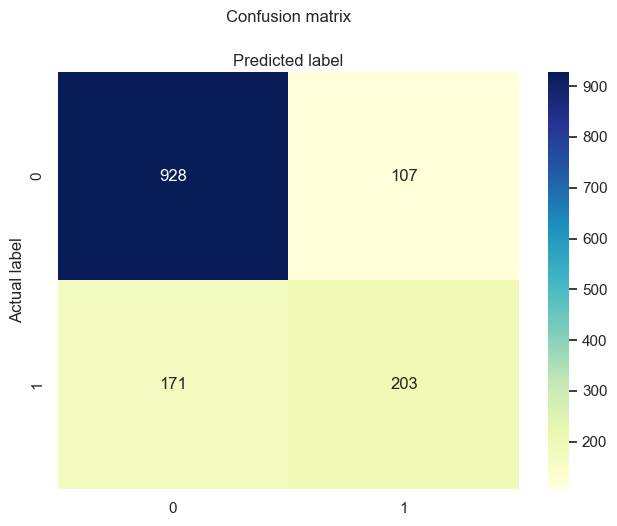

In [80]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Decision Tree Classification Model

In [81]:
# Create a decision tree model with a maximum depth of 3
dtc = DecisionTreeClassifier(max_depth=3, random_state=1)

# Train the model
dtc.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dtc.predict(X_test)
proba_dtc = dtc.predict_proba(X_test)[:, 1]

# Calculate the accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, proba_dtc):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7864
ROC-AUC: 0.7934
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1035
           1       0.67      0.38      0.49       374

    accuracy                           0.79      1409
   macro avg       0.74      0.66      0.68      1409
weighted avg       0.77      0.79      0.76      1409



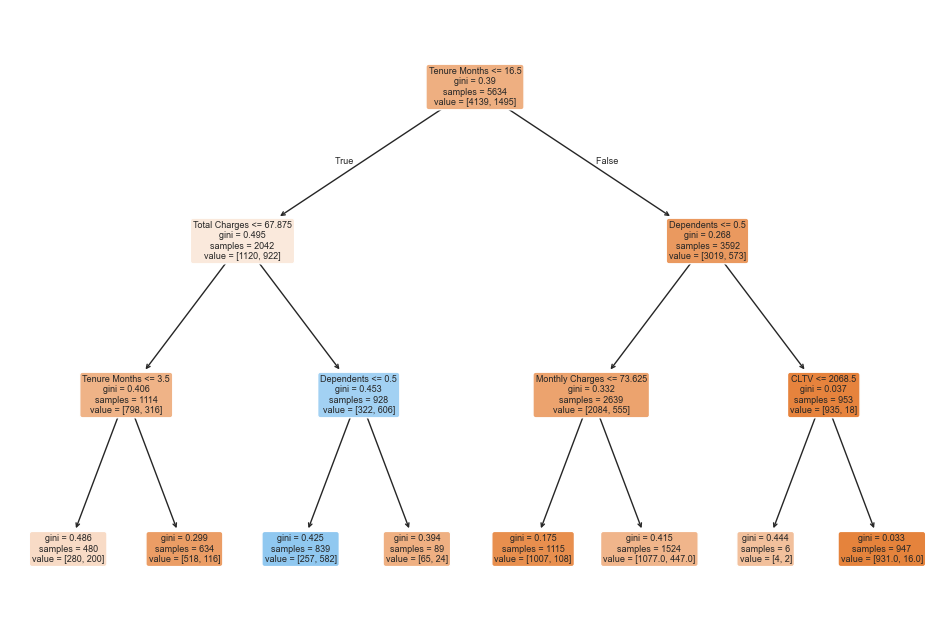

In [82]:
plt.figure(figsize=(12,8))
plot_tree(dtc,
          feature_names=numeric_features,
          filled=True,
          rounded=True)
plt.show()

We can see that `Tenure Months`, `Total Charges`, `Dependents`, and `Monthly Charges` are crucial features that the decision tree model uses to predict whether a customer churns.

In [83]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[966,  69],
       [232, 142]])

Text(0.5, 427.9555555555555, 'Predicted label')

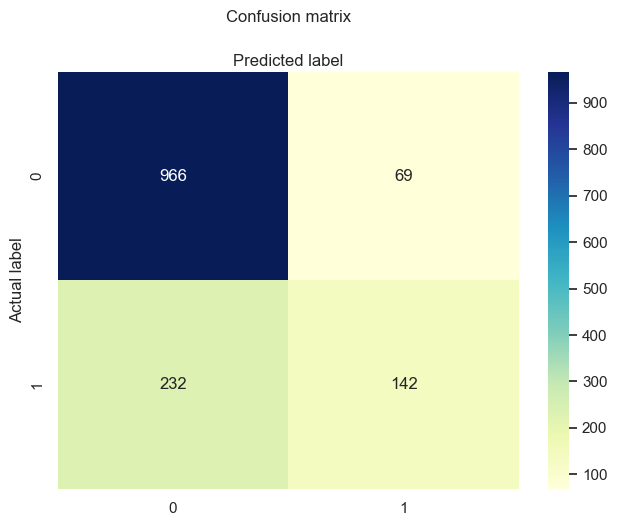

In [84]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

So far, the logistic regression model does slightly better than the decision tree with an accuracy score of 0.81 > 0.79

### Random Forest Model

In [85]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
proba_rf = rf_model.predict_proba(X_test)[:, 1]


# Calculate the accuracy score
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, proba_rf):.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7892
ROC-AUC: 0.8296
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



In [86]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[934, 101],
       [196, 178]])

Text(0.5, 427.9555555555555, 'Predicted label')

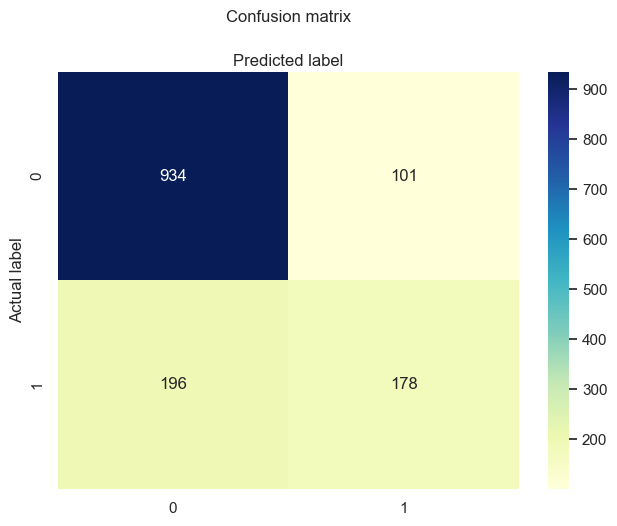

In [87]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

We can see that this random forest model does slightly better than decision tree model in almost all metrics. This can particularly be seen in the ROC-AUC curve, which is a lot more than the accuracy, and F1-Score. This is expected as random forests generally provides higher accuracy and robustness by reducing overfitting especially for more complex tasks.

## Conclusions

All in all, all models did well in predicting the data with all having an accuracy over 78% and weighted average for precision, recall, and F1-Score all above 75%

Now the decision in picking the best machine learning algorithm rests on what we want and what we are willing to risk in a business sense.

Accuracy alone can be misleading for churn problems, so the focus should also be on precision, recall, and F1 score to evaluate how well models identify churners while balancing false positives.

We want the model with the highest accuracy, precision, recall, and F1-score.

All the models have relatively the same accuracy, but the logistic regression model does better in the other metrics compared to the other two models.

Another crucial thing for a business is that if the model were to produce an incorrect prediction, would it be better to falsely predict that the customer will leave or the customer will stay with the company?

For a conservative data analyst, the most costly error is predicting that a customer will remain with the company when, in reality, they churn. This type of false negative results in missed opportunities for intervention and customer retention. As a result, an effective churn prediction model should prioritize high recall, ensuring that as many actual churners as possible are correctly identified, even if this comes at the expense of a higher false positive rate.

Keeping this in mind, the safest choice in this aspect is still the logistic regression model since it has the lowest proportion of test predictions falsely predicting that customer would stay when they actually left. Furthermore, the logistic regression model also has the highest overall precision, recall, and F1-Score when looking at the averages of each model.

Thus, the model that performed best with our dataset in predicting whether a customer leaves or stays with the company is the **logistic regression model**.